In [1]:
import numpy as np
import csv
import casadi
from multiprocessing import Pool

In [6]:
def running_cost(x):
    return (x-1.9)*(x-1.0)*(x-0.6)*(x+0.5)*(x+1.2)*(x+2.1)

In [2]:
class OcpSingleIntegrator:

    def __init__(self, dt, w_u, u_min=None, u_max=None):
        self.dt = dt
        self.w_u = w_u
        self.u_min = u_min
        self.u_max = u_max

    def solve(self, x_init, N, X_guess=None, U_guess=None):
        self.opti = casadi.Opti()
        self.x = self.opti.variable(N+1)
        self.u = self.opti.variable(N)
        x = self.x
        u = self.u

        if(X_guess is not None):
            for i in range(N+1):
                self.opti.set_initial(x[i], X_guess[i,:])
        else:
            for i in range(N+1):
                self.opti.set_initial(x[i], x_init)
        if(U_guess is not None):
            for i in range(N):
                self.opti.set_initial(u[i], U_guess[i,:])

        self.cost = 0
        self.running_costs = [None,]*(N+1)
        for i in range(N+1):
            self.running_costs[i] = running_cost(x[i]) 
            if(i<N):
                self.running_costs[i] += self.w_u * u[i]*u[i]
            self.cost += self.running_costs[i]
        self.opti.minimize(self.cost)

        for i in range(N):
            self.opti.subject_to( x[i+1]==x[i] + self.dt*u[i] )
        if(self.u_min is not None and self.u_max is not None):
            for i in range(N):
                self.opti.subject_to( self.opti.bounded(self.u_min, u[i], self.u_max) )
        self.opti.subject_to(x[0]==x_init)

        # s_opts = {"max_iter": 100}
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
        self.opti.solver("ipopt", opts) #, s_opts)

        return self.opti.solve()

In [3]:
class Parameters:
    def __init__(self, index, N, dt, x_init, w_u, u_min, u_max):
        self.index = index
        self.N = N
        self.dt = dt
        self.w_u = w_u
        self.u_min = u_min
        self.u_max = u_max
        self.x_init = x_init
    
    def setXInit(self, x_init):
        self.x_init = x_init

    def __str__(self) -> str:
        return f"Index = {self.index} - Parameters(N={self.N}, dt={self.dt}, x_init={self.x_init}, w_u={self.w_u}, u_min={self.u_min}, u_max={self.u_max})"

In [4]:
def solveOneProblem(parameters: Parameters):
    # print(f"Solving problem with parameters: {parameters}")
    ocp = OcpSingleIntegrator(parameters.dt, parameters.w_u, parameters.u_min, parameters.u_max)
    sol = ocp.solve(parameters.x_init, parameters.N)
    print(f"==== {parameters.index} solved\n")
    return (parameters.x_init, sol.value(ocp.cost))

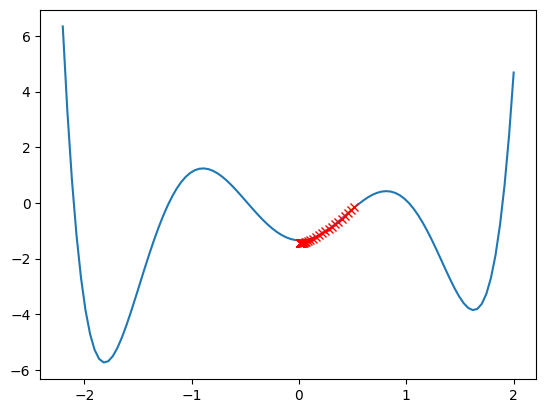

Sol:  Opti {
  instance #58
  #variables: 2 (nx = 101)
  #parameters: 0 (np = 0)
  #constraints: 101 (ng = 101)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
}
Optimal value of u:
 [-3.00000002e+00 -3.00000002e+00 -3.00000002e+00 -3.00000002e+00
 -3.00000002e+00 -3.00000002e+00 -3.00000001e+00 -3.00000001e+00
 -3.00000000e+00 -2.99999999e+00 -2.99999997e+00 -2.99999991e+00
 -2.99999943e+00 -2.51944351e+00 -1.96867073e+00 -1.53567103e+00
 -1.19651635e+00 -9.31518510e-01 -7.24805281e-01 -5.63740008e-01
 -4.38341325e-01 -3.40765559e-01 -2.64869809e-01 -2.05854189e-01
 -1.59974128e-01 -1.24311578e-01 -9.65943603e-02 -7.50542207e-02
 -5.83156362e-02 -4.53089160e-02 -3.52023909e-02 -2.73495584e-02
 -2.12479176e-02 -1.65069278e-02 -1.28230788e-02 -9.96050190e-03
 -7.73589123e-03 -6.00678058e-03 -4.66242838e-03 -3.61673042e-03
 -2.80270818e-03 -2.16822061e-03 -1.67262548e-03 -1.28417673e-03
 -9.77991336e-04 -7.34455599e-04 -5.37968915e-04 -3.75944489e-04
 -2.38003093e-

In [64]:
import matplotlib.pyplot as plt
N = 50          # horizon size
dt = 0.01        # time step
x_init = -1.0   # initial state
w_u = 1e-2
u_min = -3      # min control input
u_max = 3      # max control input
PLOT = True
SAMPLES = 2

ocp = OcpSingleIntegrator(dt, w_u, u_min, u_max)
sol = ocp.solve(np.random.uniform(-2.2, 2.0), N)
# print("Optimal value of x:\n", sol.value(ocp.x))

X = np.linspace(-2.2, 2.0, 100)
costs = [sol.value(ocp.running_costs[0], [ocp.x==x_val]) for x_val in X]
cost = 0
plt.plot(X, costs)
for i in range(N+1):
    cost += sol.value(ocp.running_costs[i])
    plt.plot(sol.value(ocp.x[i]), sol.value(ocp.running_costs[i]), 
            'xr', label='x_'+str(i))
plt.show()
print("Sol: ", sol)
print("Optimal value of u:\n", sol.value(ocp.u))
print("Optimal cost: ", sol.value(ocp.cost))

# params = [Parameters(i, N, dt, np.random.uniform(-2.2, 2.0), w_u, u_min, u_max) for i in range(SAMPLES)]

# sol = solveOneProblem(params[0])
# print(sol)

# # Plot running cost function
# if(PLOT):
#     x = np.linspace(-2, 2, 100)
#     y = running_cost(x)
#     plt.plot(x, y)
#     plt.plot(sol[0], running_cost(sol[0]), 'ro')
#     plt.show()
